<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from torch.optim import SGD, Adam
from torch.utils import data
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_snr = 18
M=16**2
NN_T = 64
NN_R=512

In [3]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M, NN_T)  # 6*6 from image dimension
        self.fc2 = nn.Linear(NN_T, NN_T)
        self.fc3 = nn.Linear(NN_T, NN_T)
        self.fc4 = nn.Linear(NN_T, 8)
        
    def forward(self, in_message):
        x = F.relu(self.fc1(in_message))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        transmitted = x / torch.sqrt(2*torch.mean(x**2))
        return transmitted
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4+4, NN_R)
        self.fc2 = nn.Linear(NN_R, NN_R)
        self.fc3 = nn.Linear(NN_R, NN_R)
        self.fc4 = nn.Linear(NN_R, M)
    def forward(self, in_message, in_channel):
        nn_input = torch.cat([in_message,in_channel],-1)
        x = F.relu(self.fc1(nn_input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        decoded = F.log_softmax(self.fc4(x), dim=-1)
        return decoded
        

In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)


criterion= nn.NLLLoss()
opt = Adam(list(encoder.parameters())+list(decoder.parameters()), lr=0.001)

Path = 'AE_open_loop_16QAM_model'

checkpoint = torch.load(Path)
encoder.load_state_dict(checkpoint['Encoder'])
decoder.load_state_dict(checkpoint['Decoder'])

<All keys matched successfully>

In [5]:
# loss = np.array([])
# gradient_steps = 100000

# train_snr=18
# t = tqdm(range(gradient_steps), desc="loss")
# for i in t:
#     t.set_description("epoch={:}".format(i))
#     ch_real = torch.randn((25600*2, 1,2))/np.sqrt(2)
#     ch_imag = torch.randn((25600*2, 1,2))/np.sqrt(2)
#     csi_real = ch_real.to(device)
#     csi_imag = ch_imag.to(device)

#     messages = np.random.randint(0,M, csi_real.shape[0])

#     train_data = torch.from_numpy(to_categorical(messages)).to(device)
#     train_label = torch.from_numpy(messages).long().to(device)


#     transmitted =encoder(train_data)
#     tx_real = transmitted[:, np.arange(0,4)].view(-1,2,2)
#     tx_imag = transmitted[:, np.arange(4,8)].view(-1,2,2)

#     rx_real = torch.bmm(csi_real, tx_real) - torch.bmm(csi_imag, tx_imag)
#     rx_imag = torch.bmm(csi_imag, tx_real) + torch.bmm(csi_real, tx_imag)

#     rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)

#     sigma = np.sqrt(0.5/(np.power(10, train_snr/10)))
#     noise = (sigma * torch.randn(rx.shape)).to(device)
#     rx = rx + noise

#     csi = torch.cat([csi_real, csi_imag], axis=-2).view(-1,4)

#     y_pred = decoder(rx, csi)
#     cross_entropy = criterion(y_pred, train_label)

#     opt.zero_grad()

#     cross_entropy.backward()
#     opt.step()


#     l = cross_entropy.to('cpu').detach().numpy()
#     loss = np.append(loss, l)







In [6]:
# #### Save the trained model
# torch.save({
#             'Encoder': encoder.state_dict(),
#             'Decoder': decoder.state_dict(),
#             }, Path)

In [7]:



SER = np.array([])
SNR_arr = np.arange(0,23,2)
t = tqdm(range(len(SNR_arr)), desc="loss")
for II in t: 
    test_snr = SNR_arr[II]
    t.set_description("SNR={:.1f}dB".format(test_snr))
    totErr = 0
    totSym = 0
    minErr = 2e4
    maxSym = minErr*1e4
    minSym = minErr*1e2
    while totErr< minErr and totSym<maxSym or totSym<minSym: 
        batch = 40
        messages = np.arange(M)
        messages = np.tile(messages, batch)
        test_labels = to_categorical(messages)

        csi_real = (torch.randn((M*batch, 1,2))/np.sqrt(2)).to(device)
        csi_imag = (torch.randn((M*batch, 1,2))/np.sqrt(2)).to(device)


        test_data = torch.from_numpy(test_labels).to(device)
        test_label = torch.from_numpy(messages).to(device)

        transmitted =encoder(test_data)
        tx_real = transmitted[:, np.arange(0,4)].view(-1,2,2)
        tx_imag = transmitted[:, np.arange(4,8)].view(-1,2,2)

        rx_real = torch.bmm(csi_real, tx_real) - torch.bmm(csi_imag, tx_imag)
        rx_imag = torch.bmm(csi_imag, tx_real) + torch.bmm(csi_real, tx_imag)

        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)


        sigma = np.sqrt(0.5/(np.power(10, test_snr/10)))
        noise = (sigma * torch.randn(rx.shape)).to(device)
        rx = rx + noise

        csi = torch.cat([csi_real, csi_imag], axis=-2).view(-1,4)

        y_pred = decoder(rx, csi)

        classification = torch.argmax(y_pred, axis=-1).to('cpu').detach().numpy()

        correct = np.equal(classification , messages)

        
        totSym = totSym + correct.shape[0]
        totErr = totErr + correct.shape[0] - np.sum(correct)
    

    SER = np.append(SER ,totErr/totSym)






SNR=22.0dB: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


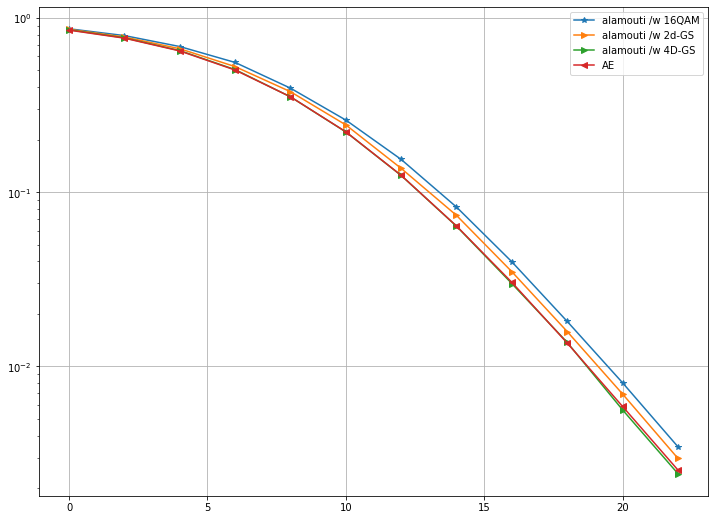

In [8]:

baseline_2dGS = np.array([0.8582738919, 0.77518119729, 0.6638753775, 0.5241933032, 0.3764218117,\
 0.2427, 0.1367,  0.07344675006,0.03492563936, 0.0158441070,0.0069469963, 0.0029697814])

baseline_4dGS = np.array([0.8525, 0.7667, 0.6476, 0.5039, 0.3517,\
 0.2212, 0.1245,  0.06367,0.02986, 0.01373,0.005634, 0.002427])

baseline_16QAM = np.array([0.863982915109450,0.789824218750000,0.683372881355932,0.553873626373626,\
0.394372549019608, 0.258779977466602, 0.153877394636015, 0.082014608979925,\
0.039804998762683, 0.018117047197906, 0.008057689702067, 0.003462703794546])

baseline_QPSK = np.array( [3.552e-1, 2.4243e-01,1.505e-01,8.094e-02,4.04150e-02,\
                    1.9156e-02,8.646e-03,3.6616e-03, 1.5502e-03,\
                    6.33910e-04, 2.53000e-04 ,1.080e-04])
plt.figure(figsize=(12,9))
# plt.semilogy(np.arange(0,23,2), baseline_QPSK,'-*', label='Alamouti w/ QPSK')


plt.semilogy(np.arange(0,24,2), baseline_16QAM, '-*', label = 'alamouti /w 16QAM')
plt.semilogy(np.arange(0,24,2), baseline_2dGS, '->', label = 'alamouti /w 2d-GS ')
plt.semilogy(np.arange(0,24,2), baseline_4dGS, '->', label = 'alamouti /w 4D-GS ')
plt.semilogy(np.arange(0,23,2), SER, '-<', label = 'AE')
                           
# , SNR_array, SER, '-o'
plt.grid()
plt.legend()